In [99]:
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors, preprocessing,tree
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split,validation_curve,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC

#### Import data and perform basic transformations
    1. Extract target variable into y
    2. Extract features into X
    3. Load data file
    4. Transform the binary predictor variable (Malign or Benign (M/B)) to 1 and 0 for further analysis
    5. Split the data into train and test

In [86]:
# Import the data file containing data about breast cancer in data frame
data = pd.read_csv('wdbc.csv')


trans = preprocessing.LabelEncoder()
# We have 30 features in this data set. 
X = data.iloc[:,2:32]

# We are interested in understanding whether cancer is malign or benign. This is the target variable.
# This variable is converted into numeric category, Malign: 1 and Benign : 0.
y = trans.fit_transform(data.iloc[:,1])

feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=4)
target_names = ['Benign','Malign']

#### CHOOSE F-1 SCORE AS THE MODEL EVALUATION METRIC

     Recall could be chosen as the scoring parameter value because of the business use case. We are interested in predicting whether a cancer is benign or malign. Here, our model can be classified as 'good' if it does not falsely classify a malign cancer as benign. Even if a benign cancer is identified as malign, it is not very harmful since this will be detected during a second opinion. Therefore, it is better to MINIMIZE THE FALSE NEGATIVES in this case.
    However, if recall is selected as the scoring parameter, the model could classify every case as 'Malign' and our results would be biased. Our interest however is still in the minority class. I have therefore selected F1-score as the evaluation metric.

##### ROC curves:
    ROC is a curve of probability. It is agnostic to the label distribution that is imbalance in the data. 
    sensitivity (TP-rate) = count(TP)/ count(TP) + count(FN) 
    specificity (FP- rate) = count(TN) / count(TN) + count(FP)
    The Y axis measures the rate (as a percentage) of correctly predicted outcomes with a positive response. The X axis measures the rate of incorrectly predicted outcomes with a negative response.
    The optimal model could be the following: Sensitivity will rise to a maximum and specificity will stay the whole time at 1. The task is to have ROC curve of the developed model as close as possible to optimal model.
    
##### Lift curves:
    Intuitively, the lift of a classifier represents the advantage it provides over random guessing. The lift is the degree to which it “pushes up” the positive instances in a list above the negative instances. 

#### K-NN Algorithm

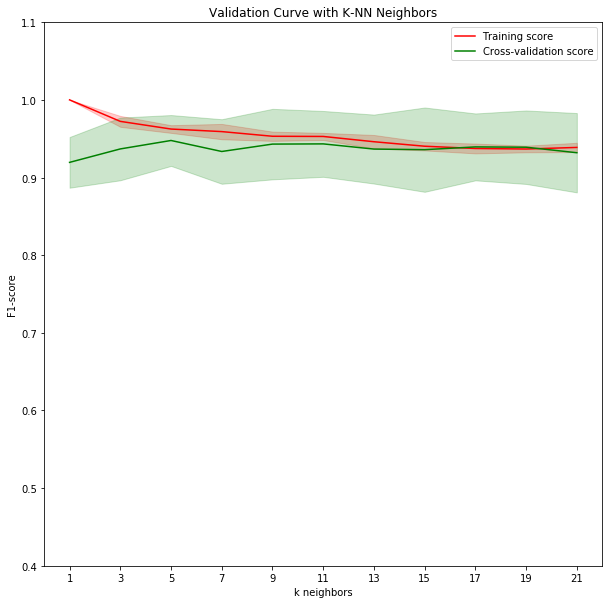

In [60]:
# Create range of values for parameter
neighbor = [1,3,5,7,9,11,13,15,17,19,21]

# Perform cross-validation and run the K-NN algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 


train_scores, test_scores = validation_curve(
    neighbors.KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors", cv=6, 
    param_range=neighbor,
    scoring="f1")

# Calculate the mean and std deviation of train and test recall values
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10,10))
plt.title("Validation Curve with K-NN Neighbors")
plt.xlabel("k neighbors")
plt.ylabel("F1-score")
plt.ylim(0.4, 1.1)

# Plot the values for recall with K ranging from 1-20
plt.plot(neighbor, train_scores_mean, label="Training score",
             color="r")
plt.fill_between(neighbor, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")

plt.plot(neighbor, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(neighbor, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.xticks(neighbor)

plt.show()

    From the above graph, when k=1, f1-score value for training set is 1.0 while f1-score value for test set is somewhere near 0.9.For k=1, model is a little complex and there are chances of overfitting. However, no overfitting can be observed from the above graph. There however is a visible improvement in the prediction provided by the test split as the complexity of the algorithm reduces, that is, value of k increases. When k reaches the value of 9, the model learns nothing and hence for k>=9, the model values should not be considered.
    

In [61]:

grid_param = {
    'weights': ['uniform','distance'],
    'n_neighbors': [1,3,5,7,9,11],
    'metric': ['euclidean', 'manhattan']
}

gd_sr = GridSearchCV(neighbors.KNeighborsClassifier(),
                     grid_param,
                     scoring='f1',
                     cv=6,
                     n_jobs=-1)

results = gd_sr.fit(X_train, y_train)
print(gd_sr.best_params_)

# We will now predict the values on test set

y_pred = gd_sr.best_estimator_.predict(X_test)
target_names = ['Benign','Malign']
classification = classification_report(y_test, y_pred, target_names=target_names,output_dict=True)
malign = classification.get("Malign")
recall_malign = malign.get("recall")
precision_malign = malign.get("precision")
f1_malign = malign.get("f1-score")
support_malign = malign.get("support")
print("Precision: ",precision_malign,"\n", "Recall: ",recall_malign,"\n","F1-score: ",f1_malign,"\n","Support: ",support_malign)
print("Confusion Matrix: ","\n","Benign","Malign" "\n",confusion_matrix(y_test, y_pred,[0,1]))

{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Precision:  0.9122807017543859 
 Recall:  0.9629629629629629 
 F1-score:  0.9369369369369369 
 Support:  54
Confusion Matrix:  
 Benign Malign
 [[112   5]
 [  2  52]]


    GridSearchCV selects the following hyper-parameter values of n_neighbors = 5, metric of measurement is euclidean and weights are uniform. With these selected hyper-parameters, we get an F1 score of 93.693% for the minority class. 2 malign cases were predicted as benign by the algorithm out of 54 malign cases.

In [66]:
scores = gd_sr.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores[:,1], drop_intermediate = False)

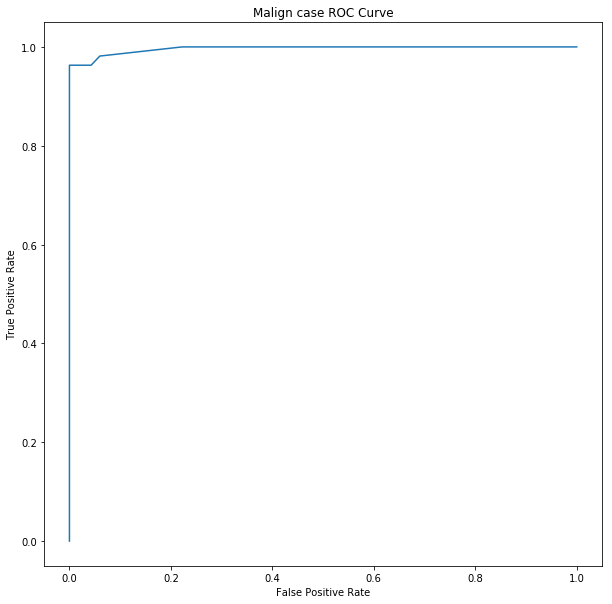

In [75]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Malign case ROC Curve')
plt.show()

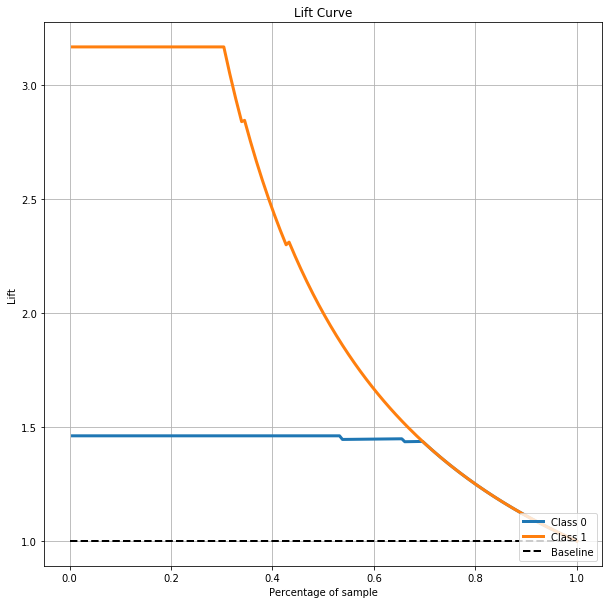

In [82]:
import scikitplot
from scikitplot.metrics import plot_lift_curve
plot_lift_curve(y_test, scores, title='Lift Curve',
ax=None, figsize=(10,10), title_fontsize='large',
text_fontsize='medium')


#### 2. Decision Tree Classification Algorithm


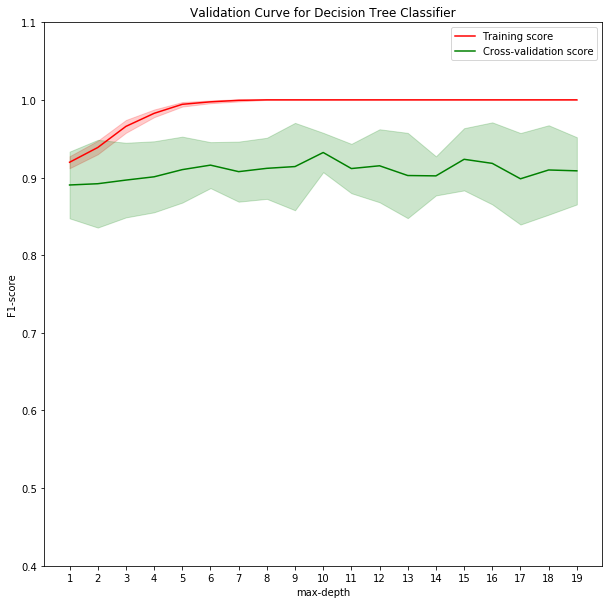

In [87]:
# Create range of values for parameter
max_depth = list(range(1,20))

# Perform cross-validation and run the decision tree algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 


train_dec, test_dec = validation_curve(
    tree.DecisionTreeClassifier(), X_train, y_train, param_name="max_depth", cv=6, 
    param_range=max_depth,
    scoring="f1")

# Calculate the mean and std deviation of train and test recall values
train_dec_mean = np.mean(train_dec, axis=1)
train_dec_std = np.std(train_dec, axis=1)
test_dec_mean = np.mean(test_dec, axis=1)
test_dec_std = np.std(test_dec, axis=1)
plt.figure(figsize=(10,10))
plt.title("Validation Curve for Decision Tree Classifier")
plt.xlabel("max-depth")
plt.ylabel("F1-score")
plt.ylim(0.4, 1.1)

# Plot the values for recall with K ranging from 1-20
plt.plot(max_depth, train_dec_mean, label="Training score",
             color="r")
plt.fill_between(max_depth, train_dec_mean - train_dec_std, train_dec_mean + train_dec_std, alpha=0.2, color="r")

plt.plot(max_depth, test_dec_mean, label="Cross-validation score",
             color="g")
plt.fill_between(max_depth, test_dec_mean - test_dec_std, test_dec_mean + test_dec_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.xticks(max_depth)

plt.show()

    From the above graph, when max-depth is 1, F1-score value on training data is low since the model is too simple. As the model is learning and the value of max-depth goes on increasing, f1-score is also increasing for the training data. This pattern is observed till max-depth <= 6. After this, the model seems to be learning nothing new. The curve for test data is pretty constant.
    No overfitting is observed for max-depth values from 1-20 here.
    

In [88]:
import warnings 
warnings.filterwarnings("ignore")
# Select list of hyper-parameters to be passed for tuning to the model

grid_param_tree = {
    'criterion': ['gini','entropy'],
    'max_depth': list(range(1,7)),
    'min_samples_split': [2],
    'min_samples_leaf' : list(range(1,10))
}

# Use gridsearchcv for hyper parameter tuning
gd_sr_tree = GridSearchCV(tree.DecisionTreeClassifier(),
                     grid_param_tree,
                     scoring='f1',
                     cv=10,
                     n_jobs=-1)

results_tree = gd_sr_tree.fit(X_train, y_train)
print(gd_sr_tree.best_params_)

# We will now predict the values on test set

y_pred_tree = gd_sr_tree.best_estimator_.predict(X_test)
target_names = ['Benign','Malign']

# Create classification report for reporting the results
classification_tree = classification_report(y_test, y_pred_tree, target_names=target_names,output_dict=True)
malign = classification_tree.get("Malign")
recall_malign = malign.get("recall")
precision_malign = malign.get("precision")
f1_malign = malign.get("f1-score")
support_malign = malign.get("support")
print("Precision: ",precision_malign,"\n", "Recall: ",recall_malign,"\n","F1-score: ",f1_malign,"\n","Support: ",support_malign)

# Create confusion matrix
print("Confusion Matrix: ","\n","Benign","Malign" "\n",confusion_matrix(y_test, y_pred_tree,[0,1]))

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Precision:  0.819672131147541 
 Recall:  0.9259259259259259 
 F1-score:  0.8695652173913043 
 Support:  54
Confusion Matrix:  
 Benign Malign
 [[106  11]
 [  4  50]]


    GridSearchCV selects the hyper-parameter values of max_depth = 5, criterion is gini, min_sample_leaf value is 5 and min_samples_split is 2. With these selected hyper-parameters, we get an F1 score of 88.13559% for the minority class. 2 malign cases were predicted as benign by the algorithm out of 54 cases. 
    The F1-score is lower than the one generated by K-NN algorithm. K-NN is thus better than decision tree for building a model on this dataset.

In [93]:
scores = gd_sr_tree.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores[:,1], drop_intermediate = False)

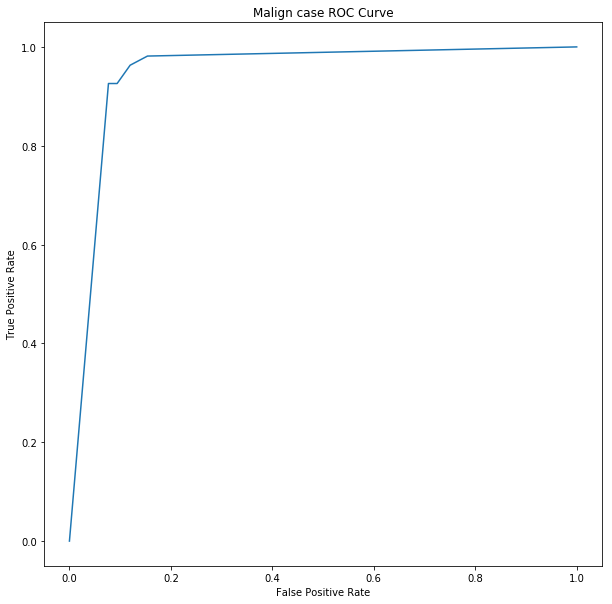

In [94]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Malign case ROC Curve')
plt.show()

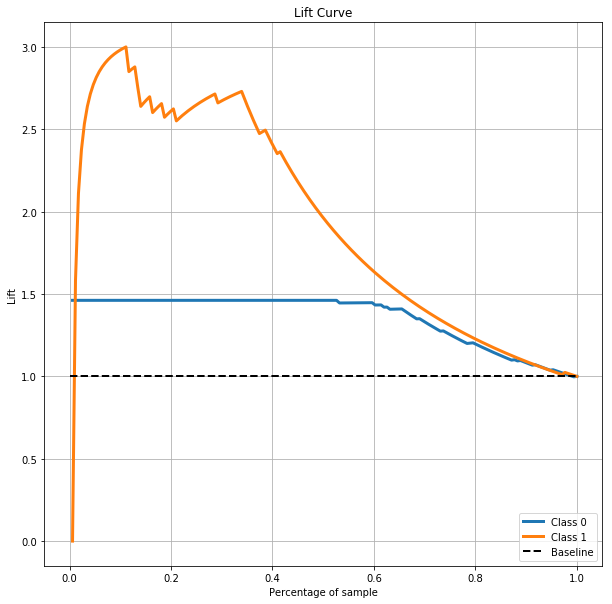

In [95]:
import scikitplot
from scikitplot.metrics import plot_lift_curve
plot_lift_curve(y_test, scores, title='Lift Curve',
ax=None, figsize=(10,10), title_fontsize='large',
text_fontsize='medium')


#### 3. Logistic Regression

In [92]:

# Hyperparameter tuning for logistic regression

grid_param_reg = {
    'penalty': ['l1','l2'],
    'random_state': [42],
    'C' : [0.001,0.01,1,1000,1e6]
}

# Pass the list of parameter to grid search to select model with the best combination of hyperparameters 
gd_sr_reg = GridSearchCV(LogisticRegression(),
                     grid_param_reg,
                     scoring='f1',
                     cv=10,
                     n_jobs=-1)

results_reg = gd_sr_reg.fit(X_train, y_train)
print(gd_sr_reg.best_estimator_)
print(gd_sr_reg.best_params_)


# We will now predict the values on test set

y_pred_reg = gd_sr_reg.best_estimator_.predict(X_test)
target_names = ['Benign','Malign']
classification_reg = classification_report(y_test, y_pred_reg, target_names=target_names,output_dict=True)
malign = classification_reg.get("Malign")
recall_malign = malign.get("recall")
precision_malign = malign.get("precision")
f1_malign = malign.get("f1-score")
support_malign = malign.get("support")
print("Precision: ",precision_malign,"\n", "Recall: ",recall_malign,"\n","F1-score: ",f1_malign,"\n","Support: ",support_malign)
print("Confusion Matrix: ","\n","Benign","Malign" "\n",confusion_matrix(y_test, y_pred_tree,[0,1]))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
{'C': 1, 'penalty': 'l1', 'random_state': 42}
Precision:  0.9137931034482759 
 Recall:  0.9814814814814815 
 F1-score:  0.9464285714285714 
 Support:  54
Confusion Matrix:  
 Benign Malign
 [[106  11]
 [  4  50]]


In [96]:
scores = gd_sr_reg.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores[:,1], drop_intermediate = False)

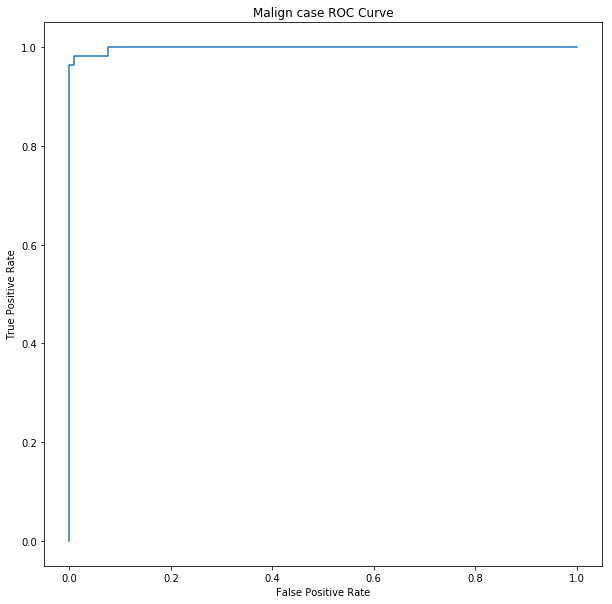

In [97]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Malign case ROC Curve')
plt.show()

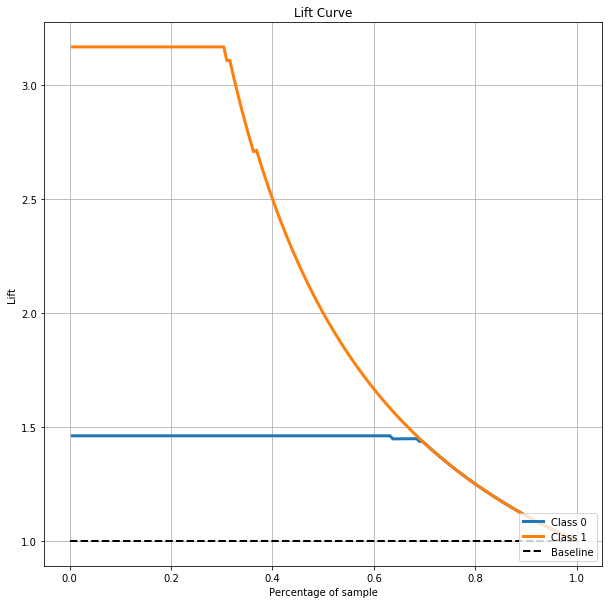

In [98]:
import scikitplot
from scikitplot.metrics import plot_lift_curve
plot_lift_curve(y_test, scores, title='Lift Curve',
ax=None, figsize=(10,10), title_fontsize='large',
text_fontsize='medium')


    GridSearchCV selects the hyper-parameter values of C = 1, penalty is l1. With these selected hyper-parameters, we get an F1 score of 94.642% for the minority class. 2 malign cases were predicted as benign by the algorithm out of 54 cases. 
    Since the value of c=1 is selected for building the model, there are very low chances of overfitting by the model that is built. 
    Between logistic regression and K-NN algorithm, any algorithm can be chosen for building a model on this dataset since the the difference in the F1-score generated by the two models is marginal. Both models have their own pros and cons. If data in question is linearly seperable, logistic regression will be the obvious choice for building the classification model since feature selection is done automatically. While for K-NN, the feature selection does not happen automatically, the decision boundary is smooth with regular piecewise geometric regions.

#### SVM Classification Algorithm

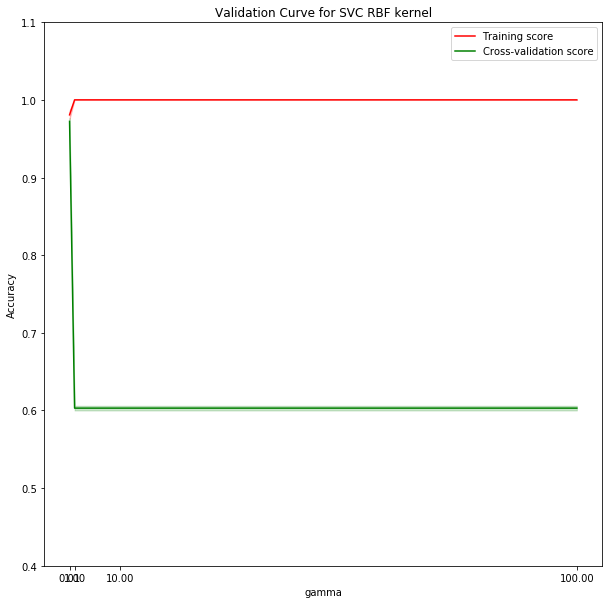

In [101]:
# Create range of values for parameter
param_g = [0.01,1,10,100]
#param_r = 
# Perform cross-validation and run the decision tree algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 


train_dec, test_dec = validation_curve(
    SVC(), X_train, y_train, cv=4, param_name ="gamma",param_range=param_g,
    scoring="accuracy")

# Calculate the mean and std deviation of train and test recall values
train_dec_mean = np.mean(train_dec, axis=1)
train_dec_std = np.std(train_dec, axis=1)
test_dec_mean = np.mean(test_dec, axis=1)
test_dec_std = np.std(test_dec, axis=1)
plt.figure(figsize=(10,10))
plt.title("Validation Curve for SVC RBF kernel")
plt.xlabel("gamma")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.1)

# Plot the values for recall with K ranging from 1-20
plt.plot(param_g, train_dec_mean, label="Training score",
             color="r")
plt.fill_between(param_g, train_dec_mean - train_dec_std, train_dec_mean + train_dec_std, alpha=0.2, color="r")

plt.plot(param_g, test_dec_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_g, test_dec_mean - test_dec_std, test_dec_mean + test_dec_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.xticks(param_g)

plt.show()

In [106]:

# Hyperparameter tuning for logistic regression

grid_param_svc = {
    'kernel': ['sigmoid','poly','linear','rbf'],
    'gamma': [0.01,1,10,100]
}

# Pass the list of parameter to grid search to select model with the best combination of hyperparameters 
gd_sr_svc = GridSearchCV(SVC(probability=True),
                     grid_param_svc,
                     scoring='f1',
                     cv=10,
                     n_jobs=-1)

results_svc = gd_sr_svc.fit(X_train, y_train)
print(results_svc.best_estimator_)
print(results_svc.best_params_)


# We will now predict the values on test set

y_pred_svc = gd_sr_svc.best_estimator_.predict(X_test)
target_names = ['Benign','Malign']
classification_svc = classification_report(y_test, y_pred_svc, target_names=target_names,output_dict=True)
malign = classification_svc.get("Malign")
recall_malign = malign.get("recall")
precision_malign = malign.get("precision")
f1_malign = malign.get("f1-score")
support_malign = malign.get("support")
print("Precision: ",precision_malign,"\n", "Recall: ",recall_malign,"\n","F1-score: ",f1_malign,"\n","Support: ",support_malign)
print("Confusion Matrix: ","\n","Benign","Malign" "\n",confusion_matrix(y_test, y_pred_tree,[0,1]))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
{'gamma': 0.01, 'kernel': 'linear'}
Precision:  0.8852459016393442 
 Recall:  1.0 
 F1-score:  0.9391304347826086 
 Support:  54
Confusion Matrix:  
 Benign Malign
 [[106  11]
 [  4  50]]


In [107]:
scores = gd_sr_svc.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores[:,1], drop_intermediate = False)

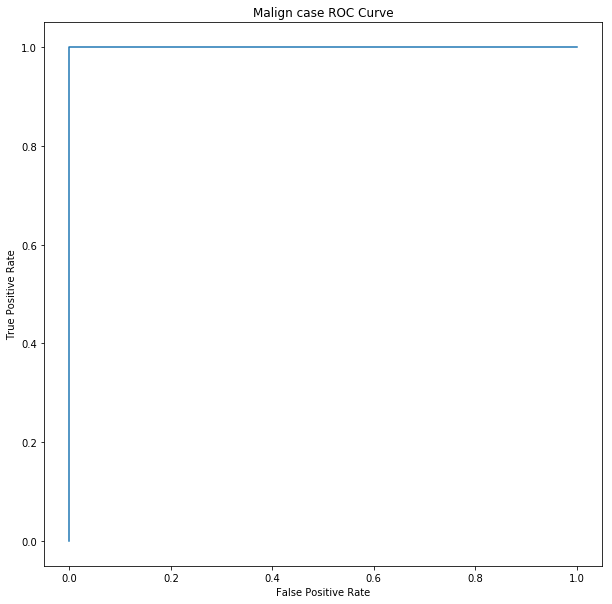

In [108]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Malign case ROC Curve')
plt.show()

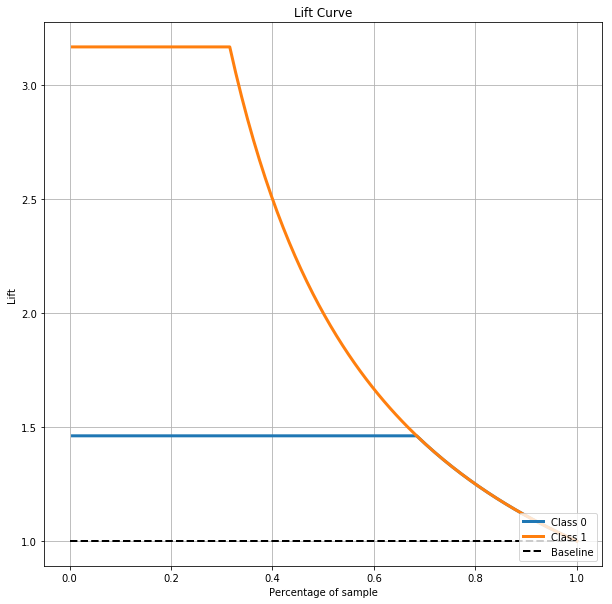

In [109]:
import scikitplot
from scikitplot.metrics import plot_lift_curve
plot_lift_curve(y_test, scores, title='Lift Curve',
ax=None, figsize=(10,10), title_fontsize='large',
text_fontsize='medium')


#### 5) [25 points] [Mining publicly available data] Download the dataset on car evaluations from http://archive.ics.uci.edu/ml/datasets/Car+Evaluation (this link also has the description of the data). This dataset has 1728 records, each record representing a car evaluation. Each car evaluation is described with 7 attributes. 6 of the attributes represent car characteristics, such as buying price, price of the maintenance, number of doors, capacity in terms of persons to carry, the size of luggage boot, and estimated safety of the car. The seventh variable represents the evaluation of the car (unacceptable, acceptable, good, very good).
#### Your task: Among the basic classification techniques that you are familiar with (i.e., decision tree, k-NN, logistic regression, NB, SVM) use all that would be applicable to this dataset to predict the evaluation of the cars based on their characteristics. Explore how well these techniques perform for several different parameter values. Present a brief overview of your predictive modeling process, explorations, and discuss your results. Present your final model (i.e., the best predictive model that you were able to come up with), and discuss its performance in a comprehensive manner (overall accuracy; per-class performance, i.e., whether this model predicts all classes equally well, or if there some classes for which it does much better than others; etc.).Note that in this classification problem your input variables are ordinal. Should you treat them as numeric or categorical? (What are pros and cons?) You can try building your models both ways; which demonstrate better predictive performance?

##### Step 1: Import all libraries required for building the model

In [119]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, tree
from sklearn.model_selection import GridSearchCV,StratifiedKFold,cross_val_score,validation_curve, learning_curve
from sklearn.metrics import classification_report, accuracy_score, make_scorer, precision_score
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import category_encoders
from sklearn import neighbors, preprocessing,tree

##### Step 2: Import the data required for performing model computation

In [120]:
colnames = ['buying_price', 'maintenance_price', 'num_doors', 'capacity', 'luggage_boot_size','estimated_car','evaluation']
data = pd.read_csv('car.data', header=None, names=colnames)
X = data.iloc[:,:6]
y = data.iloc[:,6:]

##### Step 3 (a): Perform one hot encoding on features since its categorical and scikit learn needs the data to be transformed to perform any computation

In [121]:
encoder = preprocessing.OneHotEncoder()
x_encoded = encoder.fit_transform(X)
y = np.array(y)

#### Step 3 (b) : Transform data to numeric while keeping the order in the data intact. In order to compare performance of algorithm on both categorical and numeric data, transforming the data is required.

##### Assumption while transforming data to numerical data: 
     I am assuming that there is equal distance between the different categories of data. I am making this assumption because I do not know anything about the weights that are associated with each of these individual categories. A few of the classes are '5 or more'. Since I do not have any domain knowledge to quantify these classes, I am assuming equal distance between all the categories.

In [122]:
ordinal_mappings = [{"col": "buying_price",
  "mapping": {"vhigh":4,
              "high":3,
              "med":2,
              "low":1
}},{"col": "maintenance_price",
  "mapping": {"vhigh":4,
              "high":3,
              "med":2,
              "low":1
}},{"col": "num_doors",
  "mapping": {"2":2,
              "3":3,
              "4":4,
              "5more":5
}},{"col": "capacity",
  "mapping": {"2":2,  
              "4":4,
              "more":5
}},{"col": "luggage_boot_size",
  "mapping": {"small":1,  
              "med":2,
              "big":3
}},{"col": "estimated_car",
  "mapping": {"low":1,  
              "med":2,
              "high":3
}}]
encoder = category_encoders.OrdinalEncoder(mapping = ordinal_mappings, return_df = True)
X_ord_encoded = encoder.fit_transform(X)
y = np.array(y)

##### Pros and cons of transforming ordinal data to continuous(numeric):
    The upsides:

    1. This gives you a lot of flexibility in your choice of analysis and preserves the information in the ordering.

    2. More importantly to many analysts, it allows you to analyze the data using techniques that your audience is familiar with and easily understands. The argument is that even if results are approximations, they’re understandable approximations.

    The downside: This approach requires the assumption that the numerical distance between each set of subsequent categories is equal.

    If that assumption is very close to reality–the distances are approximately equal–then analyses based on these numbers will render results that are very close to reality.  This assumption is sometimes very close and sometimes so far away.  It’s unwise to assume it’s reasonable without some consideration.
    
##### Pros and cons of transforming ordinal data to nominal(categoric):
    The downside: depending on the effect of the ordering, you could fail to answer your research question if the ordering is part of it.

    The upside: the effect of the ordering may not be all that big or all that important, and you can be sure that you’re not overstating any effects.  If anything, this approach is conservative.

In [69]:
acc_prec = list()
acc_recall = list()
acc_f1 = list()
unacc_prec = list()
unacc_recall = list()
unacc_f1 = list()
good_prec = list()
good_recall = list()
good_f1 = list()
vgood_prec = list()
vgood_recall = list()
vgood_f1 = list()


In [123]:
def classification_report_with_accuracy_score(y_true, y_pred):
    report = classification_report(y_true, y_pred,output_dict=True)
 
    acc_prec.append((report.get("acc")).get("precision"))
    acc_recall.append((report.get("acc")).get("recall"))
    acc_f1.append((report.get("acc")).get("f1-score"))
    
    unacc_prec.append((report.get("unacc")).get("precision"))
    unacc_recall.append((report.get("unacc")).get("recall"))
    unacc_f1.append((report.get("unacc")).get("f1-score"))
    
    good_prec.append((report.get("good")).get("precision"))
    good_recall.append((report.get("good")).get("recall"))
    good_f1.append((report.get("good")).get("f1-score"))
    
    vgood_prec.append((report.get("vgood")).get("precision"))
    vgood_recall.append((report.get("vgood")).get("recall"))
    vgood_f1.append((report.get("vgood")).get("f1-score"))

    return accuracy_score(y_true, y_pred)

 ##### Step 4: Split the data in k folds to perform nested cross-validation. I have used stratified k fold because the data is highly unbalanced. I wanted each split or fold to have all labels of my features. This is the reason why I have set shuffle to true.

In [124]:
inner_cv = StratifiedKFold(n_splits=4, random_state=40, shuffle=True)
outer_cv = StratifiedKFold(n_splits=4, random_state=40, shuffle=True) 

In [125]:
def print_output():
    t = PrettyTable()
    t.field_names = ['Class','Mean Precision','Std Dev Precision','Mean Recall','Std Dev Recall','Mean F1-score','Std Dev F1-Score']
    t.add_row(['acc',round(np.mean(np.asarray(acc_prec, dtype = np.float64)),2), \
           round(np.std(np.asarray(acc_prec, dtype = np.float64)),2),\
           round(np.mean(np.asarray(acc_recall, dtype = np.float64)),2),\
           round(np.std(np.asarray(acc_recall, dtype = np.float64)),2),\
           round(np.mean(np.asarray(acc_f1, dtype = np.float64)),2),\
           round(np.std(np.asarray(acc_f1, dtype = np.float64)),2)])
    t.add_row(['unacc',round(np.mean(np.asarray(unacc_prec, dtype = np.float64)),2),\
           round(np.std(np.asarray(unacc_prec, dtype = np.float64)),2),\
           round(np.mean(np.asarray(unacc_recall, dtype = np.float64)),2),\
           round(np.std(np.asarray(unacc_recall, dtype = np.float64)),2),\
           round(np.mean(np.asarray(unacc_f1, dtype = np.float64)),2),\
           round(np.std(np.asarray(unacc_f1, dtype = np.float64)),2)])
    t.add_row(['good',round(np.mean(np.asarray(good_prec, dtype = np.float64)),2),\
           round(np.std(np.asarray(good_prec, dtype = np.float64)),2),\
           round(np.mean(np.asarray(good_recall, dtype = np.float64)),2),\
           round(np.std(np.asarray(good_recall, dtype = np.float64)),2),\
           round(np.mean(np.asarray(good_f1, dtype = np.float64)),2),\
           round(np.std(np.asarray(good_f1, dtype = np.float64)),2)])
    t.add_row(['vgood',round(np.mean(np.asarray(vgood_prec, dtype = np.float64)),2),\
           round(np.std(np.asarray(vgood_prec, dtype = np.float64)),2),\
           round(np.mean(np.asarray(vgood_recall, dtype = np.float64)),2),\
           round(np.std(np.asarray(vgood_recall, dtype = np.float64)),2),\
           round(np.mean(np.asarray(vgood_f1, dtype = np.float64)),2),\
           round(np.mean(np.std(vgood_f1, dtype = np.float64)),2)])
    return t

#### 1. Decision Tree algorithm for categorical and numeric data

##### Decision Tree validation curve for categorical data

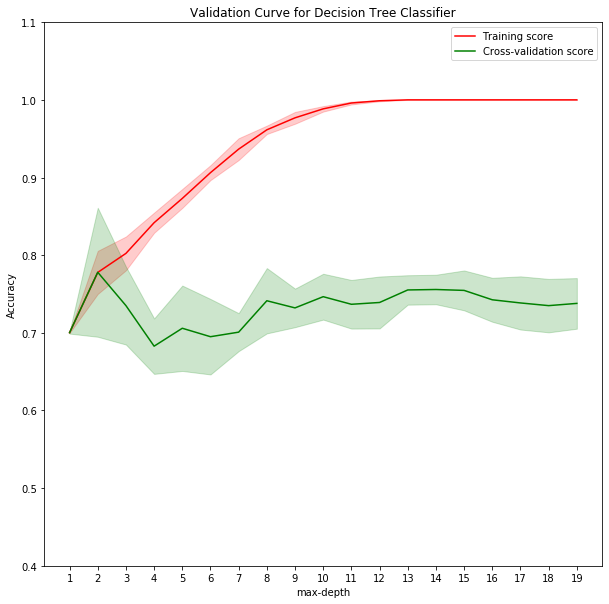

In [43]:
# Create range of values for parameter
max_depth = list(range(1,20))

# Perform cross-validation and run the decision tree algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 


train_dec, test_dec = validation_curve(
    tree.DecisionTreeClassifier(), x_encoded, y, param_name="max_depth", cv=4, 
    param_range=max_depth,
    scoring="accuracy")

def plot_decision_tree(train_dec, test_dec):
    # Calculate the mean and std deviation of train and test recall values
    train_dec_mean = np.mean(train_dec, axis=1)
    train_dec_std = np.std(train_dec, axis=1)
    test_dec_mean = np.mean(test_dec, axis=1)
    test_dec_std = np.std(test_dec, axis=1)
    plt.figure(figsize=(10,10))
    plt.title("Validation Curve for Decision Tree Classifier")
    plt.xlabel("max-depth")
    plt.ylabel("Accuracy")
    plt.ylim(0.4, 1.1)

# Plot the values for recall with K ranging from 1-20
    plt.plot(max_depth, train_dec_mean, label="Training score",
             color="r")
    plt.fill_between(max_depth, train_dec_mean - train_dec_std, train_dec_mean + train_dec_std, alpha=0.2, color="r")

    plt.plot(max_depth, test_dec_mean, label="Cross-validation score",
             color="g")
    plt.fill_between(max_depth, test_dec_mean - test_dec_std, test_dec_mean + test_dec_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.xticks(max_depth)

    plt.show()
    
plot_decision_tree(train_dec, test_dec)

##### Decision tree validation curve for numeric data

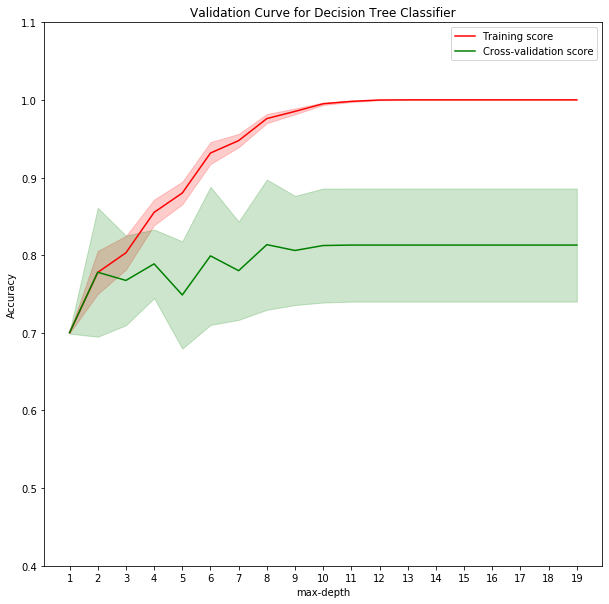

In [44]:
# Create range of values for parameter
max_depth = list(range(1,20))

# Perform cross-validation and run the decision tree algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 


train_dec, test_dec = validation_curve(
    tree.DecisionTreeClassifier(), X_ord_encoded, y, param_name="max_depth", cv=4, 
    param_range=max_depth,
    scoring="accuracy")

plot_decision_tree(train_dec, test_dec)

##### Decision Tree algorithm performance for ordinal data: 

In [89]:
#Hyper parameters for grid search
grid_param_tree = {
    'criterion': ['gini','entropy'],
    'max_depth': list(range(1,12)),
    'min_samples_leaf' : list(range(1,15))
    }

gd_sr_tree = GridSearchCV(tree.DecisionTreeClassifier(),
                     grid_param_tree,
                     scoring= 'accuracy',
                     cv=inner_cv,
                     n_jobs=3)
nested_score_cat = cross_val_score(gd_sr_tree, X=x_encoded, y=y, cv=outer_cv, \
                               scoring=make_scorer(classification_report_with_accuracy_score))



##### Reset all values to null for next model evaluation

In [93]:
acc_prec = list()
acc_recall = list()
acc_f1 = list()
unacc_prec = list()
unacc_recall = list()
unacc_f1 = list()
good_prec = list()
good_recall = list()
good_f1 = list()
vgood_prec = list()
vgood_recall = list()
vgood_f1 = list()

##### Decision Tree algorithm for numeric (ordinal) data:

In [94]:
nested_score_num = cross_val_score(gd_sr_tree, X=X_ord_encoded, y=y, cv=outer_cv, \
                               scoring=make_scorer(classification_report_with_accuracy_score))



##### Decision Tree performance evaluation : Ordinal v/s Numeric

In [90]:
# Print the final results for decision tree for CATEGORICAL DATA

print("Decision tree mean model accuracy for categorical data: ", round(np.mean(nested_score_cat),2))
t = print_output()
print(t)


Decision tree mean model accuracy for categorical data:  0.96
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
| Class | Mean Precision | Std Dev Precision | Mean Recall | Std Dev Recall | Mean F1-score | Std Dev F1-Score |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
|  acc  |      0.92      |        0.03       |     0.93    |      0.02      |      0.92     |       0.01       |
| unacc |      0.98      |        0.01       |     0.99    |      0.01      |      0.98     |       0.01       |
|  good |      0.88      |        0.13       |     0.84    |      0.08      |      0.85     |       0.06       |
| vgood |      0.95      |        0.06       |     0.82    |      0.04      |      0.88     |       0.05       |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+


    For 'good' class the decision tree is predicting with a precision of 88% and standard deviation of 13%. Similarly, recall is 84% and a standard deviation of 8%. The model is thus unable to predict 'good' class with a high precision. For all other classes, the model performance is descent for all other classes with standard deviation <= 6%.

In [95]:
# Print the final results for decision tree for NUMERIC DATA

print("Decision tree mean model accuracy for numeric data: ", round(np.mean(nested_score_num),2))
t = print_output()
print(t)


Decision tree mean model accuracy for numeric data:  0.97
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
| Class | Mean Precision | Std Dev Precision | Mean Recall | Std Dev Recall | Mean F1-score | Std Dev F1-Score |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
|  acc  |      0.94      |        0.03       |     0.95    |      0.01      |      0.95     |       0.01       |
| unacc |      0.99      |        0.0        |     0.99    |      0.01      |      0.99     |       0.01       |
|  good |      0.93      |        0.05       |     0.87    |      0.09      |      0.89     |       0.03       |
| vgood |      0.95      |        0.05       |     0.92    |      0.07      |      0.94     |       0.05       |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+


    The model predicts all classes well. Standard deviation for precision of all classes is <= 5% while recall is <= 9%. The model performance for all classes is acceptable with numeric data.

##### Performace evaluation: Numeric v/s Categorical

    Decision Tree's model accuracy is 98% for numeric data, 2% more than ordinal data. 
    Per class performance:
    For ordinal data, decision tree's mean precision for 'good' class is 88% with a standard deviation of 13%. This means that the model for categorical data is not able to predict this class very well. As opposed to categoric, the model for numeric data predicts this same 'good' class with a precision of 93% and a standard deviation of only 5%
    Decision tree model is thus predicting all classes better with numeric data than with categoric data.

#### 2. Logistic Classification Algorithm for Categorical and Numeric Data

##### Logistic regression algorithm for categorical data

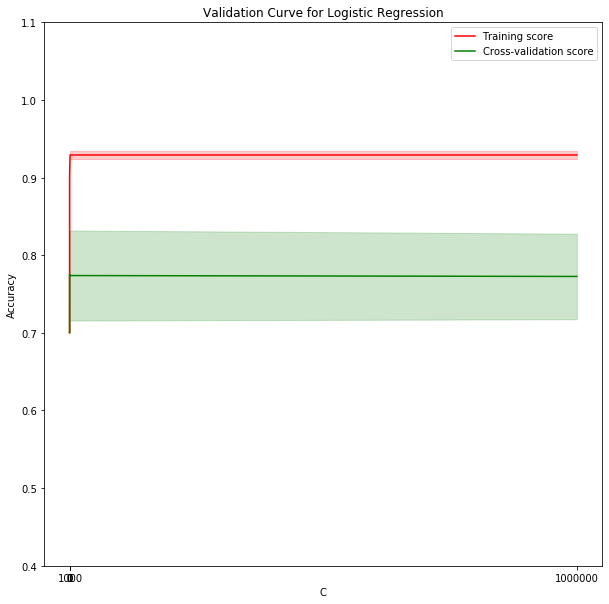

In [99]:
import warnings 
warnings.filterwarnings("ignore")
# Create range of values for parameter
param_log = [1e-6,0.001,0.01,1,1000,1e6]
#param_r = 
# Perform cross-validation and run the decision tree algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 
train_dec, test_dec = validation_curve(
    LogisticRegression(), x_encoded, y, cv=4, param_name ="C",param_range=param_log,
    scoring="accuracy")
def plot_logistic_reg(train_dec, test_dec):
    # Calculate the mean and std deviation of train and test recall values
    train_dec_mean = np.mean(train_dec, axis=1)
    train_dec_std = np.std(train_dec, axis=1)
    test_dec_mean = np.mean(test_dec, axis=1)
    test_dec_std = np.std(test_dec, axis=1)
    plt.figure(figsize=(10,10))
    plt.title("Validation Curve for Logistic Regression")
    plt.xlabel("C")
    plt.ylabel("Accuracy")
    plt.ylim(0.4, 1.1)

# Plot the values for recall with K ranging from 1-20
    plt.plot(param_log, train_dec_mean, label="Training score",
             color="r")
    plt.fill_between(param_log, train_dec_mean - train_dec_std, train_dec_mean + train_dec_std, alpha=0.2, color="r")

    plt.plot(param_log, test_dec_mean, label="Cross-validation score",
             color="g")
    plt.fill_between(param_log, test_dec_mean - test_dec_std, test_dec_mean + test_dec_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.xticks(param_log)

    plt.show()
    
plot_logistic_reg(train_dec, test_dec)

##### Logistic regression algorithm for numeric data

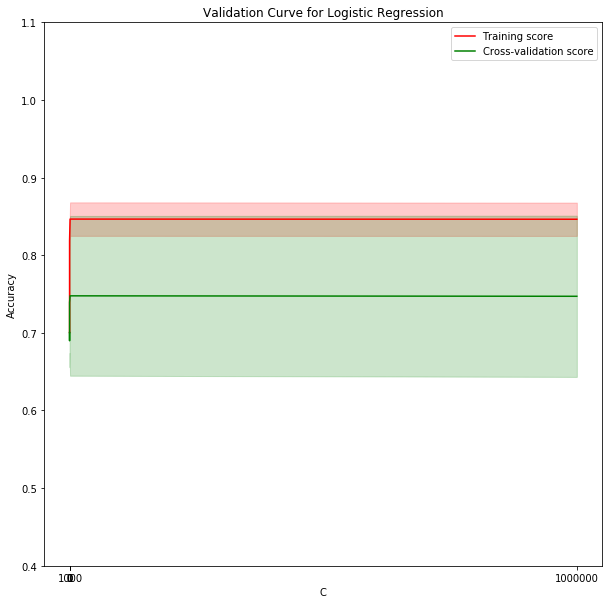

In [100]:
import warnings 
warnings.filterwarnings("ignore")
# Create range of values for parameter
param_log = [1e-6,0.001,0.01,1,1000,1e6]
#param_r = 
# Perform cross-validation and run the decision tree algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 
train_dec, test_dec = validation_curve(
    LogisticRegression(), X_ord_encoded, y, cv=4, param_name ="C",param_range=param_log,
    scoring="accuracy")
plot_logistic_reg(train_dec, test_dec)

##### Logistic Classification Algorithm performance for ordinal data

In [107]:
grid_param_reg = {
    'penalty': ['l1','l2'],
    'random_state': [42],
    'solver': ['saga'],
    'C' : [1e-6,0.001,0.01,1,1000,1e6]
}

# Pass the list of parameter to grid search to select model with the best combination of hyperparameters 
gd_sr_reg = GridSearchCV(LogisticRegression(),
                     grid_param_reg,
                     scoring='accuracy',
                     cv=inner_cv,
                     n_jobs=-1)
nested_score = cross_val_score(gd_sr_reg, X=x_encoded, y=y, cv=outer_cv, \
                               scoring=make_scorer(classification_report_with_accuracy_score))

##### Reset all values to null for next model evaluation

In [109]:
acc_prec = list()
acc_recall = list()
acc_f1 = list()
unacc_prec = list()
unacc_recall = list()
unacc_f1 = list()
good_prec = list()
good_recall = list()
good_f1 = list()
vgood_prec = list()
vgood_recall = list()
vgood_f1 = list()

##### Logistic regression algorithm for numeric (ordinal) data:

In [110]:
nested_score = cross_val_score(gd_sr_reg, X=X_ord_encoded, y=y, cv=outer_cv, \
                               scoring=make_scorer(classification_report_with_accuracy_score))

##### Logistic Classification algorithm performance evaluation : Ordinal v/s Numeric

In [108]:
# Print the final results for logistic regression for CATEGORICAL DATA

print("Overall mean logistic regression model accuracy: ", round(np.mean(nested_score),2))
t = print_output()
print(t)

Overall mean logistic regression model accuracy:  0.89
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
| Class | Mean Precision | Std Dev Precision | Mean Recall | Std Dev Recall | Mean F1-score | Std Dev F1-Score |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
|  acc  |      0.75      |        0.02       |     0.81    |      0.05      |      0.78     |       0.02       |
| unacc |      0.96      |        0.02       |     0.96    |      0.01      |      0.96     |       0.0        |
|  good |      0.52      |        0.14       |     0.28    |      0.1       |      0.34     |       0.11       |
| vgood |      0.87      |        0.03       |     0.78    |      0.11      |      0.82     |       0.05       |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+


    The model's predictive performance for 'good' class is not very good since the precision for this class is only 52% and standard deviation is as high as 14%. Similarly the recall for this class is also less. The mean recall for this class is just 28%. Logistic regression model is thus not predicting the 'good' class very well. The overall accuracy of the model is 89%.

In [111]:
# Print the final results for logistic regression for NUMERIC DATA

print("Overall mean logistic regression model accuracy: ", round(np.mean(nested_score),2))
t = print_output()
print(t)

Overall mean logistic regression model accuracy:  0.82
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
| Class | Mean Precision | Std Dev Precision | Mean Recall | Std Dev Recall | Mean F1-score | Std Dev F1-Score |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
|  acc  |      0.62      |        0.02       |     0.62    |      0.07      |      0.62     |       0.04       |
| unacc |      0.89      |        0.02       |     0.95    |      0.01      |      0.92     |       0.01       |
|  good |      0.59      |        0.1        |     0.23    |      0.04      |      0.33     |       0.04       |
| vgood |      0.58      |        0.37       |     0.27    |      0.17      |      0.36     |       0.23       |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+


    The model's predictive performance for 'vgood' class is not very good since the precision for this class is only 58% and standard deviation is as high as 37%. Similarly the recall for this class is also less. The mean recall for this class is just 27% with a standard deviation of 17%. Logistic regression model is thus not predicting the 'vgood' class very well. The overall accuracy of the model is 82%.

##### Performace evaluation: Numeric v/s Categorical

    Logistic Regression's model accuracy is 89% for categoric data, 7% more than ordinal data.
    Logistic Regression's model for categoric data is thus better than that for numeric data.

#### 3. Naive Bayes Classification

#### Naive Bayes Algorithm for Categorical Data

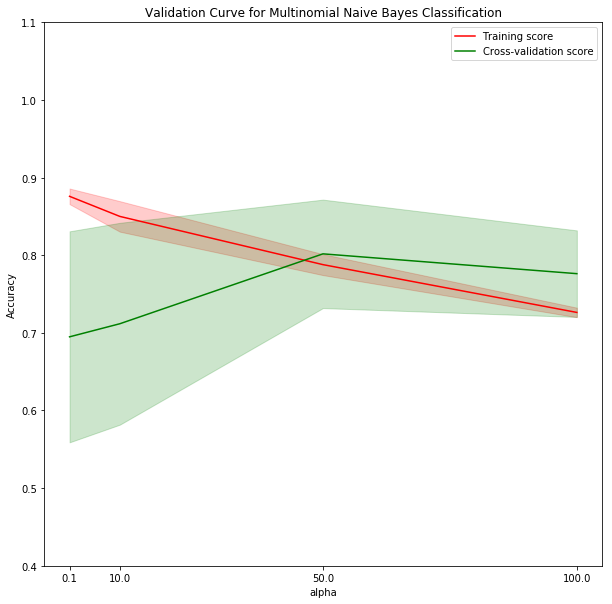

In [101]:
# Create range of values for parameter
param_r = [0.1, 10.0,50.0,100.0]

# Perform cross-validation and run the naive bayes classification algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 


train_dec, test_dec = validation_curve(
    MultinomialNB(), x_encoded, y, cv=4, param_name ="alpha",param_range=param_r,
    scoring="accuracy")

# Calculate the mean and std deviation of train and test recall values
train_dec_mean = np.mean(train_dec, axis=1)
train_dec_std = np.std(train_dec, axis=1)
test_dec_mean = np.mean(test_dec, axis=1)
test_dec_std = np.std(test_dec, axis=1)
plt.figure(figsize=(10,10))
plt.title("Validation Curve for Multinomial Naive Bayes Classification")
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.1)

# Plot the values for recall with K ranging from 1-20
plt.plot(param_r, train_dec_mean, label="Training score",
             color="r")
plt.fill_between(param_r, train_dec_mean - train_dec_std, train_dec_mean + train_dec_std, alpha=0.2, color="r")

plt.plot(param_r, test_dec_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_r, test_dec_mean - test_dec_std, test_dec_mean + test_dec_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.xticks(param_r)

plt.show()

    From the above cross validation curve, as the value of alpha is increasing, the training model accuracy is going down but the prediction accuracy is increasing. However, as the value of alpha increases beyond 50, the testing model accuracy begins to decrease. I have therefore done nested cross validation on value of alpha only till 50. 

##### Reset all values to null for next model evaluation

In [117]:
acc_prec = list()
acc_recall = list()
acc_f1 = list()
unacc_prec = list()
unacc_recall = list()
unacc_f1 = list()
good_prec = list()
good_recall = list()
good_f1 = list()
vgood_prec = list()
vgood_recall = list()
vgood_f1 = list()

##### Naive Bayes classification model performace on ordinal data (Multinomial Naive Bayes Classifier)

In [126]:
grid_param_nb = {
    "alpha": [0.1, 0,1.0, 10.0, 50.0],
    "fit_prior" : [True, False]
}

gd_sr_nb = GridSearchCV(MultinomialNB(),
                     grid_param_nb,
                     scoring='accuracy',
                     cv=inner_cv,
                     n_jobs=-1)
nested_score = cross_val_score(gd_sr_nb, X=x_encoded, y=y, cv=outer_cv, \
                               scoring=make_scorer(classification_report_with_accuracy_score))

In [127]:
# Print the final results for Multinomial NB

print("Overall mean multinomial naive bayes model accuracy: ", round(np.mean(nested_score),2))
t = print_output()
print(t)

Overall mean multinomial naive bayes model accuracy:  0.85
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
| Class | Mean Precision | Std Dev Precision | Mean Recall | Std Dev Recall | Mean F1-score | Std Dev F1-Score |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
|  acc  |      0.66      |        0.03       |     0.71    |      0.07      |      0.68     |       0.05       |
| unacc |      0.92      |        0.02       |     0.95    |      0.01      |      0.94     |       0.01       |
|  good |      0.52      |        0.15       |     0.2     |      0.06      |      0.28     |       0.07       |
| vgood |      0.98      |        0.04       |     0.52    |      0.09      |      0.67     |       0.08       |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+


    Naive Bayes classifier's model accuracy for ordinal data is 85%. The model predicts all the classes well except the 'good' class for which although the model's precision is 52%, the standard deviation is 15% but the recall is as low as 2%. The model is thus not predicting this class very well.

##### Naive Bayes classification for numeric data

    Naive Bayes classification works on probabilities. This is based on the occurrence(count) of data in the dataset. Converting this information to continuous data makes no sense because probability estimates on continuous data cannot be calculated. I have therefore not performed model evaluation for numeric data.

#### 4. Support Vector Machine (SVM) Classification Algorithm

##### Validation curve with RBF kernel for categorical data

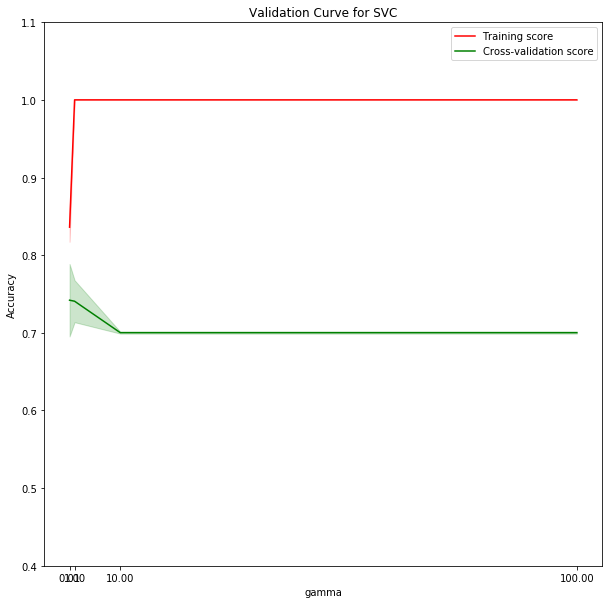

In [135]:
# Create range of values for parameter
param_g = [0.01,1,10,100]
#param_r = 
# Perform cross-validation and run the decision tree algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 


train_dec, test_dec = validation_curve(
    SVC(kernel='rbf'), x_encoded, y.ravel(), cv=4, param_name ="gamma",param_range=param_g,
    scoring="accuracy")

def plot_svm(train_dec, test_dec):
    # Calculate the mean and std deviation of train and test recall values
    train_dec_mean = np.mean(train_dec, axis=1)
    train_dec_std = np.std(train_dec, axis=1)
    test_dec_mean = np.mean(test_dec, axis=1)
    test_dec_std = np.std(test_dec, axis=1)
    plt.figure(figsize=(10,10))
    plt.title("Validation Curve for SVC")
    plt.xlabel("gamma")
    plt.ylabel("Accuracy")
    plt.ylim(0.4, 1.1)

    # Plot the values for recall with K ranging from 1-20
    plt.plot(param_g, train_dec_mean, label="Training score",
             color="r")
    plt.fill_between(param_g, train_dec_mean - train_dec_std, train_dec_mean + train_dec_std, alpha=0.2, color="r")

    plt.plot(param_g, test_dec_mean, label="Cross-validation score",
             color="g")
    plt.fill_between(param_g, test_dec_mean - test_dec_std, test_dec_mean + test_dec_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.xticks(param_g)
    plt.show()


plot_svm(train_dec, test_dec)

##### Validation curve with RBF kernel for numeric data

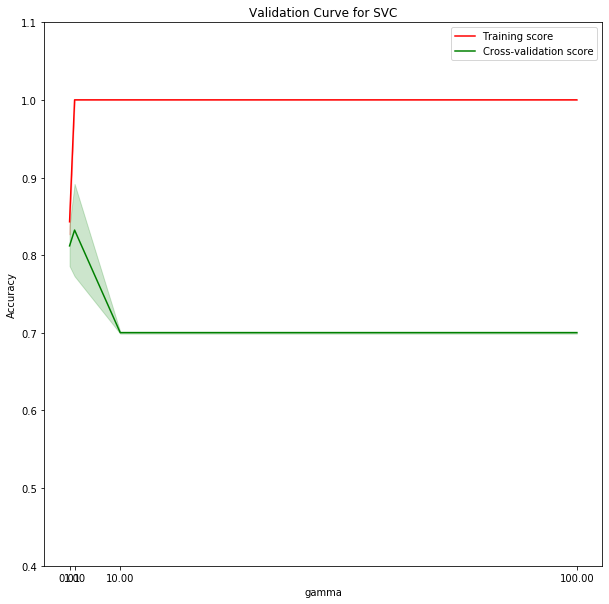

In [139]:
# Create range of values for parameter
param_g = [0.01,1,10,100]
#param_r = 
# Perform cross-validation and run the decision tree algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 


train_dec, test_dec = validation_curve(
    SVC(kernel='rbf'), X_ord_encoded, y.ravel(), cv=4, param_name ="gamma",param_range=param_g,
    scoring="accuracy")
plot_svm(train_dec, test_dec)

##### Reset all values to null for next model evaluation

In [130]:
acc_prec = list()
acc_recall = list()
acc_f1 = list()
unacc_prec = list()
unacc_recall = list()
unacc_f1 = list()
good_prec = list()
good_recall = list()
good_f1 = list()
vgood_prec = list()
vgood_recall = list()
vgood_f1 = list()

##### SVM with RBF kernel for categorical data

In [131]:
import warnings 
warnings.filterwarnings("ignore")
grid_param_svc = {
    "gamma" : [0.01,1,10,100]
}

gd_sr_svc = GridSearchCV(SVC(kernel='rbf'),
                     grid_param_svc,
                     scoring='accuracy',
                     cv=inner_cv,
                     n_jobs=6)
nested_score = cross_val_score(gd_sr_svc, X=x_encoded, y=y.ravel(), cv=outer_cv, \
                               scoring=make_scorer(classification_report_with_accuracy_score))

##### SVM with RBF kernel for numeric data

In [133]:
nested_score = cross_val_score(gd_sr_svc, X=X_ord_encoded, y=y.ravel(), cv=outer_cv, \
                               scoring=make_scorer(classification_report_with_accuracy_score))

##### Performance for SVM for RBF kernel for categorical v/s numeric data

In [21]:
# Print the final results for SVM with RBF kernel for CATEGORICAL DATA

print("Overall mean SVC model accuracy for RBF kernel: ", round(np.mean(nested_score),2))
t = print_output()
print(t)

Overall mean SVC model accuracy:  0.9
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
| Class | Mean Precision | Std Dev Precision | Mean Recall | Std Dev Recall | Mean F1-score | Std Dev F1-Score |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
|  acc  |      0.75      |        0.02       |     0.86    |      0.04      |      0.8      |       0.03       |
| unacc |      0.95      |        0.02       |     1.0     |      0.0       |      0.97     |       0.01       |
|  good |      0.25      |        0.43       |     0.01    |      0.02      |      0.03     |       0.05       |
| vgood |      1.0       |        0.0        |     0.22    |      0.13      |      0.34     |       0.16       |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+


    The SVM model has an accuracy of 90% with RBF kernel for categoric data. The model's precision and recall for 'good' class is not very efficient. For 'good' class, the mean precision value is 25% with a standard deviation of 43%. The mean recall value is also only 1%. The model is thus not predicting 'good' class very accurately.

In [134]:
# Print the final results for SVM with RBF kernel for NUMERIC DATA

print("Overall mean SVC model accuracy for RBF kernel: ", round(np.mean(nested_score),2))
t = print_output()
print(t)

Overall mean SVC model accuracy for RBF kernel:  0.98
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
| Class | Mean Precision | Std Dev Precision | Mean Recall | Std Dev Recall | Mean F1-score | Std Dev F1-Score |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
|  acc  |      0.95      |        0.02       |     0.96    |      0.02      |      0.96     |       0.02       |
| unacc |      0.99      |        0.0        |     1.0     |      0.0       |      0.99     |       0.0        |
|  good |      0.93      |        0.08       |     0.86    |      0.06      |      0.89     |       0.03       |
| vgood |      0.97      |        0.03       |     0.89    |      0.05      |      0.93     |       0.02       |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+


    SVM model with RBF kernel for numeric data has an accuracy of 98%. The model predicts all the classes with high precision and recall.  

##### Performace evaluation: Numeric v/s Categorical

     SVM Model's accuracy with RBF kernel for categorical data is 90%
     SVM Model's accuracy with RBF kernel for numeric data is 98%
         SVM Model with RBF kernel performs better with numeric data since it predicts all classes with high precision and recall. With categoric data, the model's prediction performance for 'good' class is not very high.

##### Validation curve with polynomial kernel for categorical data

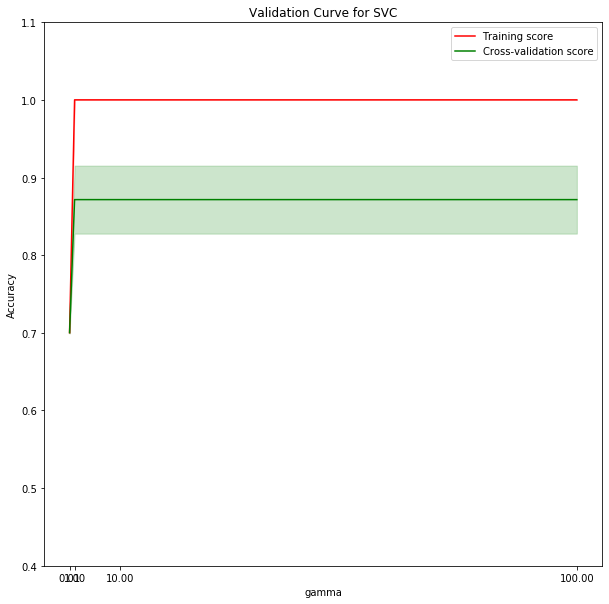

In [138]:
# Create range of values for parameter
param_g = [0.01,1,10,100]
#param_r = 
# Perform cross-validation and run the decision tree algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 


train_dec, test_dec = validation_curve(
    SVC(kernel='poly'), x_encoded, y.ravel(), cv=4, param_name ="gamma",param_range=param_g,
    scoring="accuracy")

plot_svm(train_dec, test_dec)

##### Reset all values to null for next model evaluation

In [140]:
acc_prec = list()
acc_recall = list()
acc_f1 = list()
unacc_prec = list()
unacc_recall = list()
unacc_f1 = list()
good_prec = list()
good_recall = list()
good_f1 = list()
vgood_prec = list()
vgood_recall = list()
vgood_f1 = list()

##### SVM Model Performance for Polynomial kernel with categorical data

In [141]:
grid_param_svc = {
    "gamma" : [0.01,1],
    "degree" : [2,3,4,5,6]
}

gd_sr_svc = GridSearchCV(SVC(kernel='poly'),
                     grid_param_svc,
                     scoring='accuracy',
                     cv=inner_cv,
                     n_jobs=6)
nested_score = cross_val_score(gd_sr_svc, X=x_encoded, y=y.ravel(), cv=outer_cv, \
                               scoring=make_scorer(classification_report_with_accuracy_score))

##### Model performance for SVM with polynomial kernel 

In [142]:
# Print the final results for SVM model with polynomial kernel 

print("Overall mean SVC model accuracy for polynomial kernel: ", round(np.mean(nested_score),2))
t = print_output()
print(t)

Overall mean SVC model accuracy for polynomial kernel:  1.0
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
| Class | Mean Precision | Std Dev Precision | Mean Recall | Std Dev Recall | Mean F1-score | Std Dev F1-Score |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
|  acc  |      0.99      |        0.01       |     1.0     |      0.0       |      0.99     |       0.01       |
| unacc |      1.0       |        0.0        |     1.0     |      0.0       |      1.0      |       0.0        |
|  good |      1.0       |        0.0        |     0.94    |      0.07      |      0.97     |       0.04       |
| vgood |      0.99      |        0.03       |     0.99    |      0.03      |      0.98     |       0.02       |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+


    SVM gives an accuracy of 100% for polynomial kernel with categoical data. It predicts all the classes with high precision recall. This model is the best for predicting car evaluation.

##### Validation curve with linear kernel for categorical data

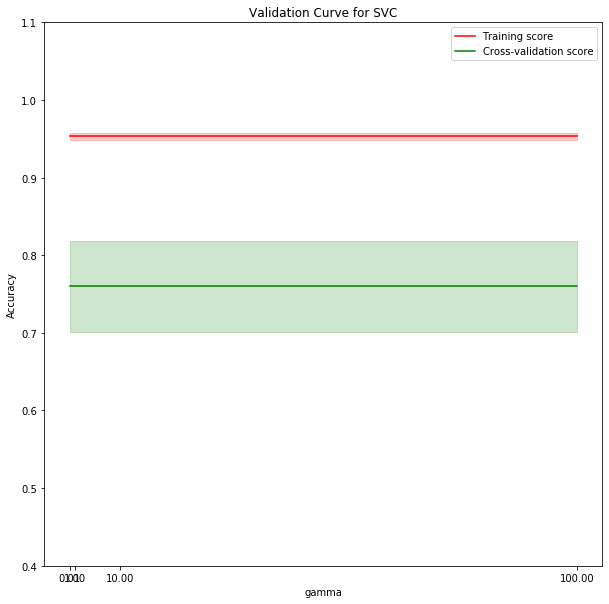

In [144]:
# Create range of values for parameter
param_g = [0.01,1,10,100]
#param_r = 
# Perform cross-validation and run the decision tree algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 


train_dec, test_dec = validation_curve(
    SVC(kernel='linear'), x_encoded, y.ravel(), cv=4, param_name ="gamma",param_range=param_g,
    scoring="accuracy")
plot_svm(train_dec, test_dec)

##### Validation curve with linear kernel for numeric data

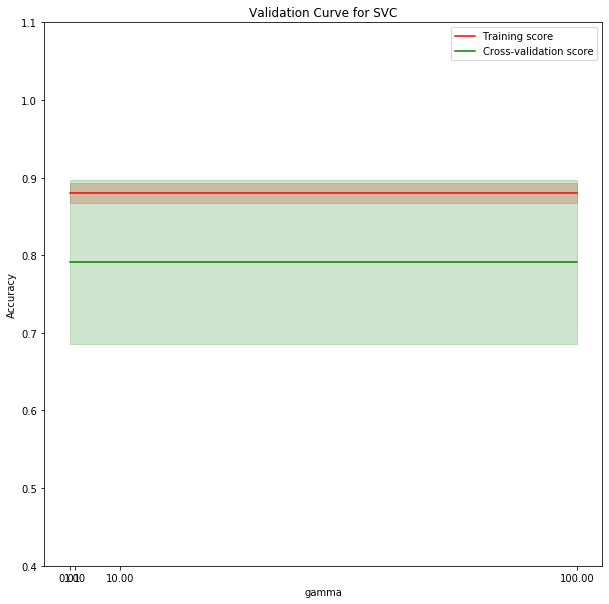

In [145]:
# Create range of values for parameter
param_g = [0.01,1,10,100]
#param_r = 
# Perform cross-validation and run the decision tree algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 


train_dec, test_dec = validation_curve(
    SVC(kernel='linear'), X_ord_encoded, y.ravel(), cv=4, param_name ="gamma",param_range=param_g,
    scoring="accuracy")
plot_svm(train_dec, test_dec)

##### Reset all values to null for next model evaluation

In [146]:
acc_prec = list()
acc_recall = list()
acc_f1 = list()
unacc_prec = list()
unacc_recall = list()
unacc_f1 = list()
good_prec = list()
good_recall = list()
good_f1 = list()
vgood_prec = list()
vgood_recall = list()
vgood_f1 = list()

##### SVM model with linear kernel for categorical data

In [147]:
grid_param_svc = {
    "gamma" : [0.01,1],
}

gd_sr_svc = GridSearchCV(SVC(kernel='linear'),
                     grid_param_svc,
                     scoring='accuracy',
                     cv=inner_cv,
                     n_jobs=6)
nested_score = cross_val_score(gd_sr_svc, X=x_encoded, y=y.ravel(), cv=outer_cv, \
                               scoring=make_scorer(classification_report_with_accuracy_score))

##### SVM model with linear kernel for numeric data

In [153]:
nested_score_num = cross_val_score(gd_sr_svc, X=X_ord_encoded, y=y.ravel(), cv=outer_cv, \
                               scoring=make_scorer(classification_report_with_accuracy_score))

##### SVM model performance for linear kernel: categorical v/s numeric data

In [148]:
# Print the final results for SVM LINEAR kernel with CATEGORICAL DATA

print("Overall mean SVC model accuracy for linear kernel: ", round(np.mean(nested_score),2))
t = print_output()
print(t)

Overall mean SVC model accuracy for linear kernel:  0.93
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
| Class | Mean Precision | Std Dev Precision | Mean Recall | Std Dev Recall | Mean F1-score | Std Dev F1-Score |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
|  acc  |      0.85      |        0.03       |     0.87    |      0.05      |      0.86     |       0.01       |
| unacc |      0.97      |        0.02       |     0.96    |      0.01      |      0.96     |       0.0        |
|  good |      0.82      |        0.07       |     0.75    |      0.07      |      0.78     |       0.04       |
| vgood |      0.89      |        0.06       |     1.0     |      0.0       |      0.94     |       0.03       |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+


    SVM's model accuracy for linear kernel is 93% with categorical data. The model predicts all classes well but not as good as SVM with polynomial kernel on categorical data.

In [154]:
# Print the final results for SVM LINEAR kernel with NUMERIC DATA

print("Overall mean SVC model accuracy for linear kernel: ", round(np.mean(nested_score_num),2))
t = print_output()
print(t)

Overall mean SVC model accuracy for linear kernel:  0.87
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
| Class | Mean Precision | Std Dev Precision | Mean Recall | Std Dev Recall | Mean F1-score | Std Dev F1-Score |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
|  acc  |      0.74      |        0.01       |     0.71    |      0.07      |      0.72     |       0.04       |
| unacc |      0.92      |        0.02       |     0.94    |      0.0       |      0.93     |       0.01       |
|  good |      0.78      |        0.1        |     0.74    |      0.03      |      0.75     |       0.04       |
| vgood |      0.93      |        0.04       |     0.8     |      0.07      |      0.86     |       0.03       |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+


    SVM's model accuracy for linear kernel is 87% with categorical data. The model predicts all classes well but not as good as SVM with linear kernel on categorical data.
    SVM model with linear kernel performs better on categorical data than on numeric data.

##### Performace evaluation: Numeric v/s Categorical

    SVM Model on linear kernel with categorical data is 93%
    SVM Model on linear kernel with numeric data is 87%
    SVM Model with linear kernel on categorical data performs better than on numeric data. 

#### 5. K-NN Classification Algorithm

##### K-NN classifier on numeric data

##### Reset all values to null for next model evaluation

In [160]:
acc_prec = list()
acc_recall = list()
acc_f1 = list()
unacc_prec = list()
unacc_recall = list()
unacc_f1 = list()
good_prec = list()
good_recall = list()
good_f1 = list()
vgood_prec = list()
vgood_recall = list()
vgood_f1 = list()

##### Validation curve for K-NN with numeric data

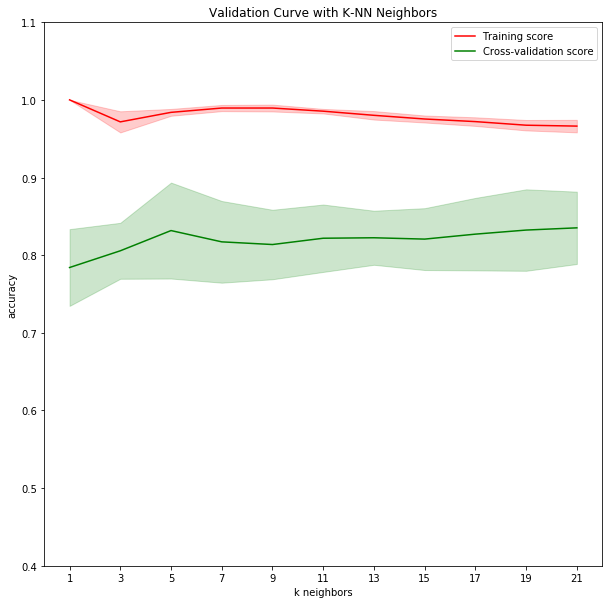

In [156]:
import warnings 
warnings.filterwarnings("ignore")
# Create range of values for parameter
neighbor = [1,3,5,7,9,11,13,15,17,19,21]

# Perform cross-validation and run the K-NN algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 


train_scores, test_scores = validation_curve(
    neighbors.KNeighborsClassifier(), X_ord_encoded, y, param_name="n_neighbors", cv=6, 
    param_range=neighbor,
    scoring="accuracy")

# Calculate the mean and std deviation of train and test recall values
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10,10))
plt.title("Validation Curve with K-NN Neighbors")
plt.xlabel("k neighbors")
plt.ylabel("accuracy")
plt.ylim(0.4, 1.1)

# Plot the values for recall with K ranging from 1-20
plt.plot(neighbor, train_scores_mean, label="Training score",
             color="r")
plt.fill_between(neighbor, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")

plt.plot(neighbor, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(neighbor, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.xticks(neighbor)

plt.show()

##### Validation curve for K-NN with categorical data

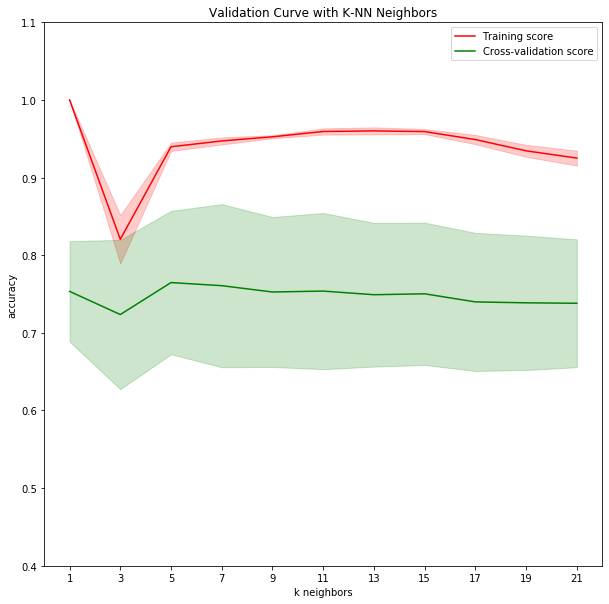

In [159]:
import warnings 
warnings.filterwarnings("ignore")
# Create range of values for parameter
neighbor = [1,3,5,7,9,11,13,15,17,19,21]

# Perform cross-validation and run the K-NN algorithm on training data which generated scores
# about the prediction which can then be used to identify how well our model is performing on data that it has
# seen before and on data that it has never seen before. 


train_scores, test_scores = validation_curve(
    neighbors.KNeighborsClassifier(), x_encoded, y, param_name="n_neighbors", cv=6, 
    param_range=neighbor,
    scoring="accuracy")

# Calculate the mean and std deviation of train and test recall values
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10,10))
plt.title("Validation Curve with K-NN Neighbors")
plt.xlabel("k neighbors")
plt.ylabel("accuracy")
plt.ylim(0.4, 1.1)

# Plot the values for recall with K ranging from 1-20
plt.plot(neighbor, train_scores_mean, label="Training score",
             color="r")
plt.fill_between(neighbor, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")

plt.plot(neighbor, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(neighbor, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.xticks(neighbor)

plt.show()

##### K-NN model performace on numeric data

In [157]:
import warnings 
warnings.filterwarnings("ignore")

grid_param = {
    'weights': ['uniform','distance'],
    'n_neighbors': [1,3,5,7,9,11],
    'metric': ['euclidean', 'manhattan']
}

gd_sr_tree = GridSearchCV(neighbors.KNeighborsClassifier(),
                     grid_param,
                     scoring= 'accuracy',
                     cv=inner_cv,
                     n_jobs=3)
nested_score = cross_val_score(gd_sr_tree, X=X_ord_encoded, y=y, cv=outer_cv, \
                               scoring=make_scorer(classification_report_with_accuracy_score))

##### Model performance on numeric data for K-NN

In [158]:
# Print the final results for K-NN classifier on numeric data

print("Overall mean decision tree model accuracy: ", round(np.mean(nested_score),2))
t = print_output()
print(t)


Overall mean decision tree model accuracy:  0.95
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
| Class | Mean Precision | Std Dev Precision | Mean Recall | Std Dev Recall | Mean F1-score | Std Dev F1-Score |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
|  acc  |      0.89      |        0.02       |     0.92    |      0.04      |      0.91     |       0.03       |
| unacc |      0.98      |        0.01       |     0.99    |      0.0       |      0.98     |       0.01       |
|  good |      0.85      |        0.09       |     0.74    |      0.11      |      0.78     |       0.04       |
| vgood |      1.0       |        0.0        |     0.8     |      0.08      |      0.89     |       0.05       |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+


    K-NN has a prediction accuracy of 95% with numeric data.
    It predicts all classes with a high precision and recall. The recall for 'vgood' class is 8% which is a little low but the tradeoff is balance with precision which is 100%.

##### K-NN classifier for categorical data

In [161]:
nested_score_cat = cross_val_score(gd_sr_tree, X=x_encoded, y=y, cv=outer_cv, \
                               scoring=make_scorer(classification_report_with_accuracy_score))

In [162]:
# Print the final results for K-NN classifier on numeric data

print("Overall mean decision tree model accuracy: ", round(np.mean(nested_score_cat),2))
t = print_output()
print(t)


Overall mean decision tree model accuracy:  0.91
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
| Class | Mean Precision | Std Dev Precision | Mean Recall | Std Dev Recall | Mean F1-score | Std Dev F1-Score |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+
|  acc  |      0.79      |        0.04       |     0.85    |      0.03      |      0.82     |       0.03       |
| unacc |      0.96      |        0.01       |     0.98    |      0.01      |      0.97     |       0.0        |
|  good |      0.78      |        0.13       |     0.28    |      0.09      |      0.4      |       0.11       |
| vgood |      0.98      |        0.04       |     0.63    |      0.09      |      0.76     |       0.07       |
+-------+----------------+-------------------+-------------+----------------+---------------+------------------+


    K-NN has a prediction accuracy of 91% with categoric data.
    It predicts all classes with a high precision and recall. The precision for 'good' class is 73% but the standard deviation is a little high, 13%

##### Performace evaluation: Numeric v/s Categorical

    K-NN Model predictive performance with categorical data is 91%
    K-NN Model predictive performance with with numeric data is 95%
    K-NN performs better with numeric data than with categoric data.

##### Model with best predictive performance:

    SVM model with polynomial kernel on categorical data has the best predictive performance among all the models presented above.